# import necessary libraries

In [6]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
import re



# functions

In [10]:

def explore_dataframe(df):
    """
    Description
        A comprehensive tool that provides a summary of a given DataFrame.
        This function analyzes both numerical and categorical columns, performing
        various operations such as calculating basic statistics, checking data types,
        counting NaN values, and analyzing categorical column values.

    Parameters
        df (DataFrame): The pandas DataFrame that you want to explore or analyze.

    Returns
        None. The function prints to the standard output the following information:
            - Summary Information: Brief overview of the DataFrame
            - Descriptive Statistics: Basic statistical details of the DataFrame
            - Data Types: Data types of each column in the DataFrame
            - NaN Values Count: The count of NaN values in each column
            - Categorical Column Analysis: Analysis of the categorical columns

    Note
        - The function does not handle DataFrames containing columns of type 'category'.
        - The function prints the output rather than returning it. 
        - It is recommended to validate the DataFrame before using this function. 
    """
    # Check the summary information of the dataset
    print("Summary information of the dataset:")
    print(df.info(),'\n')

    # Compute basic statistics of the dataset
    print("\nDescriptive statistics of the dataset:")
    print(df.describe(),'\n')

    # Check the data type of each column
    print("Data types of each column:")
    print(df.dtypes,'\n')

    # Check the count of NaN values in each column
    print("\nCount of NaN values in each column:")
    print(df.isnull().sum(),'\n')

    # Categorical column analysis
    categorical_cols = df.select_dtypes(include='object').columns.tolist()

    for col in categorical_cols:
        print(f"\n{col} column:")
        print("-------------------------------")

        # Calculate the count and percentage of each category, including null values
        category_counts = df[col].value_counts(dropna=False)
        category_percentages = df[col].value_counts(normalize=True, dropna=False) * 100

        # Print the count and percentage of categories, including null values
        print("Count:")
        print(category_counts)
        print("\nPercentage:")
        print(category_percentages)



def fill_missing_values(df):
    """
    Fill in missing values in all columns of the DataFrame.

    For numeric columns, missing values are filled with the median value of the column.
    For categorical columns, missing values are filled with the most frequent value of the column.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.

    Returns:
        dict: A dictionary with each column and the value used for filling missing values.
    """
    fill_values = {}

    # Fill missing values in numeric columns with median
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    numeric_fill_values = df[numeric_cols].median()
    df[numeric_cols] = df[numeric_cols].fillna(numeric_fill_values)
    fill_values.update(numeric_fill_values.to_dict())

    # Fill missing values in categorical columns with most frequent value
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    for col in categorical_cols:
        categorical_fill_value = df[col].mode().iloc[0]
        df[col] = df[col].fillna(categorical_fill_value)
        fill_values[col] = categorical_fill_value

    return fill_values


def plot_data(df, max_categories=10, continuous_col=None, hue_col=None):

    """
    Description
        Plots various graphs for each column in the provided pandas DataFrame, 
        If the column 
        is numeric, it generates a histogram and a boxplot.
        If `continuous_col` and `hue_col` parameters
        are provided, it also creates a scatter plot. 
        For non-numeric (categorical) columns with unique 
        values not exceeding `max_categories`, it generates a boxplot (if `continuous_col` and `hue_col` 
        parameters are provided). 
        The function also identifies high cardinality columns (columns with unique
        values exceeding `max_categories`).

    Parameters
        df (DataFrame): The pandas DataFrame whose data you want to plot.
        max_categories (int, optional): The maximum number of unique values a column can have to be considered 
                                         for boxplot. Default is 10.
        continuous_col (str, optional): The name of the continuous variable column in the DataFrame. If provided 
                                         along with `hue_col`, a scatter plot or boxplot will be generated.
        hue_col (str, optional): The name of the hue variable column in the DataFrame. If provided along with 
                                  `continuous_col`, a scatter plot or boxplot will be generated.

    Returns
        None. It prints high cardinality columns and shows various plots based on the data type of the columns 
        and provided parameters.


    Note
        - The function ignores 'future_hour_income', 'incomeGroupUp', and 'id' columns for the plots.
        - It doesn't plot for columns with unique values exceeding `max_categories`. Instead, 
          it adds them to the high cardinality list.
    """

    list_many_categories = []
    for column in df.columns:
        if column in ['future_hour_income','incomeGroupUp','id']:
            continue
        if np.issubdtype(df[column].dtype, np.number):  # If numeric, plot histogram, boxplot, and scatter plot
            plt.figure(figsize=(15, 4))
            plt.xticks(rotation=45, ha='right')

            # Histogram
            plt.subplot(1, 3, 1)
            plt.hist(df[column].dropna(), bins=30, edgecolor='black')  # dropna to remove missing values
            plt.title(f"Histogram of {column}")

            # Boxplot
            plt.subplot(1, 3, 2)
            plt.boxplot(df[column].dropna())  # dropna to remove missing values
            plt.title(f"Boxplot of {column}")

            # Scatter plot if continuous_col and hue_col are specified
            if continuous_col and hue_col:
                plt.subplot(1, 3, 3)
                sns.scatterplot(x=column, y=continuous_col, hue=hue_col, data=df)  
                plt.title(f"Scatter plot of {continuous_col} by {column} and {hue_col}")

            plt.tight_layout()
            plt.show()

        else:  # If non-numeric (categorical), create a boxplot if continuous_col and hue_col are specified
            if df[column].nunique() > max_categories:
                list_many_categories.append(column)
                # print(f"Column '{column}' has more than {max_categories} unique values. It has {df[column].nunique()} categories.")
            else:
                if continuous_col and hue_col:
                    plt.figure(figsize=(7, 4))
                    sns.boxplot(x=column, y=continuous_col, hue=hue_col, data=df)
                    plt.xticks(rotation=45, ha='right')
                    plt.title(f"Boxplot of {continuous_col} by {column} and {hue_col}")
                    plt.show()

    print(f'high cardinality column: {list_many_categories}')


def calculate_mean(df, col_name):
    """
    Description
        The function calculates mean values based on values in a column that can be strings containing numbers. 
        The column values are split based on underscore ('_') or hyphen ('-'). 

    Parameters
        df (DataFrame): The pandas DataFrame whose column's mean you want to calculate.
        col_name (str): The name of the column in the DataFrame whose mean you want to calculate.

    Returns
        DataFrame. It returns the DataFrame with a new column for mean values and without the original column.

    Note
        - The function assumes that the column values are either numeric strings or strings containing 
          numbers separated by underscore ('_') or hyphen ('-').
        - If a value is a string that doesn't contain a number, None will be assigned to the new mean 
          column for that row.
    """
    # Initialize a new column for mean values
    df[f'new_mean_{col_name}'] = None

    # Define a lambda function to calculate mean
    def calc_mean(row):
        if isinstance(row[col_name], str):
            if '_' in row[col_name]:
                # Split the strings into two parts and calculate the mean
                #print(map(int, row[col_name].split('_')))
                try:
                    part1, part2 = map(int, row[col_name].split('_'))
                    return (part1 + part2) / 2
                except:
                    part1, part2,part3 = map(int, row[col_name].split('_'))
                    return (part1 + part2+part3) / 2
            elif '-' in row[col_name]:
                # Split the strings into two parts and calculate the mean
                part1, part2 = map(int, row[col_name].split('-'))
                return (part1 + part2) / 2
            else:
                # Extract numbers from the string
                numbers = re.findall(r'\d+', row[col_name])
                if numbers:
                    return sum(map(int, numbers)) / len(numbers)
                else:
                    return None  # or some default value

    # Apply the function to each row
    
    df[f'new_mean_{col_name}'] = df.apply(calc_mean, axis=1)
    df = df.drop(col_name,axis=1)
    return df


def fill_categorical_cols_with_many_missing_values(df, nan_threshold_in_percent,fill_value):
    """
    Fills NaN values in categorical columns of a DataFrame with the string 'other'
    if the number of NaNs in a column exceeds a specified threshold.
    
    Additionally, this function prints the number of NaNs in each categorical column.
    
    Args:
    df (pandas.DataFrame): The input DataFrame.
    nan_threshold (int): The threshold for the number of NaNs. If a column has more NaNs
                         than this threshold, the NaNs will be replaced with 'other'.

    Returns:
    pandas.DataFrame: The DataFrame with NaN values filled for categorical columns
                      exceeding the nan_threshold.
    """
    
    for col in df.columns:
        if df[col].dtype == 'object':
            percent_nans = df[col].isnull().sum()/len(data) *100
            print(f"percent of NaNs in {col}: {percent_nans}")
            if percent_nans > nan_threshold_in_percent:
                print(f"fill missing values in {col}: with the value: {fill_value}")
                df[col].fillna(fill_value, inplace=True)
    return df


def check_target_variable(df, target_col):
    """
    Checks and prints the key characteristics of a target variable in a DataFrame.
    
    Args:
    df (pandas.DataFrame): The input DataFrame.
    target_col (str): The name of the target column.

    Returns:
    None
    """
    
    # Check if target_col exists in df
    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' is not in DataFrame columns.")
        
    target = df[target_col]
    target.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 1. Check type of variable
    unique_vals = target.dropna().unique()
    if pd.api.types.is_numeric_dtype(target) and len(unique_vals) > 3:
        print(f"{target_col} is a continuous variable.")
        
        # Calculate the percentage of zero values
        percentage_zeros = len(df[df[target_col] == 0])/len(df) * 100
        print(f"Percentage of zero values: {percentage_zeros:.2f}%")
        if percentage_zeros>30:
            print('could suggest zero inflation')
        
        # 3.Skewness and Kurtosis
        print(f"Skewness: {target.skew()}")
        skew = target.skew()
        if (skew > 1):  # If the skewness is greather than 1 (extremely positive skewed)
            print(f'target is extremely positive skewed')
        elif (skew > 0.5) & (skew < 1): # between 0.5 & 1(slightly positive skewed)
            print(f'target is slightly positive skewed')
            
        elif (skew <0.5) & (skew > -0.5): # If the skewness is between -0.5 & 0.5, the data are nearly symmetrical.
            print(f'target is nearly symmetrical')
            
        elif (skew < -0.5) & (skew > -1): # If the skewness is between -1 & -0.5 (negative skewed) 
            print(f'target is slightly negative skewed')
            
        elif (skew < -1):  # If the skewness is lower than -1 (extremely negative skewed)
            print(f'target is extremely negative skewed')
        
            
        print(f"Kurtosis: {target.kurt()}")
        kurt = target.kurt()
        if kurt > 3:
            print('Leptokurtic - has very long and skinny tails, with more chances of outliers.')
        elif kurt < 3:
            print('Platykurtic - having a lower tail and stretched around center tails means most data points are present in high proximity to the mean. ')
        elif kurt ==3:
            print('Mesokurtic - the same as the normal distribution')
        # 4.Normality test (Shapiro-Wilk Test)
        stat, p = stats.shapiro(target)
        print(f"P-value for Shapiro-Wilk Test (Normality Test): {p}")
        if p<0.05:
            print(f'because p is smaller than 0.05 we can say that the target data is not normally distributed!!')
        
        #2. Distribution of continuous variable
        plt.figure(figsize=(10, 4))
        plt.xticks(rotation=45, ha='right')
        plt.subplot(1, 2, 1)
        plt.hist(target.dropna(), bins=30, edgecolor='black')  # dropna to remove missing values
        plt.title(f"Histogram of {target_col}")

        plt.subplot(1, 2, 2)
        plt.boxplot(target.dropna())  # dropna to remove missing values
        plt.title(f"Boxplot of {target_col}")

        plt.tight_layout()
        plt.show()
    
        
        
    else:
        print(f"{target_col} is a categorical or binary variable.")
        
        # 2. Distribution of categories
        sns.countplot(x=target)
        plt.title(f"Distribution of {target_col}")
        plt.show()

    # 4. Missing Values
    missing_vals = target.isnull().sum()
    print(f"Number of missing values: {missing_vals}")
    
    # 5. Check if the data is balanced (only for binary/categorical target)
    if not pd.api.types.is_numeric_dtype(target) or len(unique_vals) <= 3:
        value_counts = target.value_counts()
        value_counts_per = target.value_counts(normalize=True, dropna=False) * 100
        print("Counts of each class:\n", value_counts)
        print("percent of each class:\n", value_counts_per)



def frequency_encoding(data, column, mode='train', freq_dict=None):
    """
    Frequency Encoding on a categorical column in a DataFrame.
    Args:
        data (pandas.DataFrame): The DataFrame containing the categorical column.
        column (str): The name of the categorical column.
        mode (str): The mode of operation. Either 'train' or 'production'.
        freq_dict (dict): The frequency dictionary from the training phase.

    Returns:
        dict: The frequency dictionary containing the frequencies of each category.
        pandas.DataFrame: The DataFrame with the encoded column.
    """
    if mode == 'train':
        freq_dict = data[column].value_counts(normalize=True).to_dict()
        encoded_column = data[column].replace(freq_dict)
        return freq_dict, pd.concat([data.drop(column, axis=1), encoded_column.rename(column)], axis=1)
    elif mode == 'production':
        if freq_dict is None:
            raise ValueError("Frequency dictionary is missing in production mode.")
        
        unknown_categories = data[~data[column].isin(freq_dict.keys())][column].values
        print(unknown_categories)
        most_frequent_value = max(freq_dict.values())
        print(f'most_frequent_value: {most_frequent_value}')

        encoded_column = data[column].replace(freq_dict)
        encoded_column = encoded_column.replace(unknown_categories,most_frequent_value)
        return pd.concat([data.drop(column, axis=1), encoded_column.rename(column)], axis=1)
    else:
        raise ValueError("Invalid mode. Mode should be either 'train' or 'production'.")



def one_hot_encode(data, categorical_columns, mode, encoder):
    """
    Perform one-hot encoding on categorical columns of a DataFrame.

    Args:
        data (pandas.DataFrame): The input DataFrame.
        categorical_columns (list): A list of column names to one-hot encode.
        mode (str): The mode of operation. Either 'train' or 'production'.
        encoder (sklearn.preprocessing.OneHotEncoder): The trained encoder from the training phase.

    Returns:
        If mode is 'train':
            sklearn.preprocessing.OneHotEncoder: The fitted encoder object.
            pandas.DataFrame: The encoded dataset.

        If mode is 'production':
            pandas.DataFrame: The encoded dataset.
    """
    # Separate categorical and numeric columns
    categorical_data = data[categorical_columns].reset_index(drop='True')
    numeric_data = data.drop(categorical_columns, axis=1).reset_index(drop='True')
        
    if mode == 'train':
        # Create the OneHotEncoder object
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

        # Perform one-hot encoding on categorical data
        encoded_data = encoder.fit_transform(categorical_data)

        # Get the feature names for the encoded data
        feature_names = encoder.get_feature_names_out(categorical_data.columns)

        # Create a DataFrame with the encoded categorical data and column headers
        encoded_df = pd.DataFrame(encoded_data, columns=feature_names)
        print(mode,encoded_df.shape, numeric_data.shape)
        # Concatenate the encoded categorical data with the numeric data
        encoded_data = pd.concat([encoded_df, numeric_data], axis=1)

        # Return the encoder and the encoded dataset
        return encoder, encoded_data

    elif mode == 'production':

        # Perform one-hot encoding on categorical data using the trained encoder
        encoded_data = encoder.transform(categorical_data)

        # Get the feature names for the encoded data
        feature_names = encoder.get_feature_names_out(categorical_data.columns)

        # Create a DataFrame with the encoded categorical data and column headers
        encoded_df = pd.DataFrame(encoded_data, columns=feature_names)
        print(mode,encoded_df.shape, numeric_data.shape)
        # Concatenate the encoded categorical data with the numeric data
        encoded_data = pd.concat([encoded_df, numeric_data], axis=1)

        # Return the encoded dataset
        return encoded_data

    
def scale_data(df, scaler, mode, cols_to_scale):
    """
    Scales the data using the provided scaler.

    Args:
    df (pandas.DataFrame): The input DataFrame.
    scaler (StandardScaler, MinMaxScaler): The scaler to use.
    mode (str): The mode to use. Can be 'train' or 'production'.
    cols_to_scale (list): The list of column names to be scaled.

    Returns:
    pandas.DataFrame, StandardScaler: The scaled DataFrame and the fitted scaler.
    """
    if mode == 'train':
        scaler.fit(df[cols_to_scale])
        scaled_cols_df = pd.DataFrame(scaler.transform(df[cols_to_scale]), columns=cols_to_scale)
    elif mode == 'production':
        scaled_cols_df = pd.DataFrame(scaler.transform(df[cols_to_scale]), columns=cols_to_scale)
    else:
        raise ValueError(f"Invalid mode '{mode}'. Mode must be either 'train' or 'production'.")

    # Combine scaled and non-scaled columns
    df_scaled = pd.concat([df.drop(columns=cols_to_scale), scaled_cols_df], axis=1)
    
    return df_scaled, scaler


# לקלוט את קובץ הנתונים ל  Python

In [11]:
data = pd.read_excel(r'C:\Users\nirro\Downloads\DS_Home_Exam.xlsx','table')
data.head()

,id,matzavbriut,k_gova,k_mishkal,k_safaikarit,labour_force_participation,gilGroup,MeanIncomeGroup,hashavani,chipesshana,teudagvoha,k_shnlimklali,k_sug_mosad,m_eretz,mazav,mamadavoda,mekabelsachar,min,semelmishlach,safanosefetanglit,k_semelmiktzlim,incomeGroupUp,future_hour_income
0,5990004,VeryGood,179_175,74_70,Hebrew,False,22-25,7777,Never,NaN,Post_secondaryschooldiploma_non_academictrack_,13_15,NaN,Israel,Nevermarried,NaN,NaN,Male,NaN,yes,NaN,False,0.000
1,2930001,Good,169_165,74_70,Hebrew,False,76-80,7,YesUsually,no,Nodiplomaordegree,NaN,NaN,Asia,Widowed,NaN,NaN,Male,NaN,no,NaN,False,0.000
2,10930001,VeryGood,190andmore,89_85,Hebrew,True,41-45,7,Rarely,NaN,Firstacademicdegree_BAorsimilardegree_,16andmore,NaN,Israel,Married,SelfEmployed,NaN,Male,Managers,yes,business,False,0.000
3,42280001,NotsoGood,NaN,109_105,Russian,True,51-55,5640,Never,NaN,Primaryschoolorintermediateschooldiploma,13_15,NaN,Euorope_America,Divorced,Employed,FromWorkingPlace,Male,Managers,yes,NaN,False,33.125
4,36560004,VeryGood,NaN,64_60,Hebrew,False,NaN,7,NaN,no,Secondaryschooldiplomaג€“matriculationcertificate,11_12,NaN,Israel,Nevermarried,NaN,NaN,Male,NaN,yes,NaN,True,0.000


# EDA


In [12]:
# explore the dataframe using pandas methods info() describe() dtypes()
explore_dataframe(df=data)

Summary information of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          511 non-null    int64  
 1   matzavbriut                 510 non-null    object 
 2   k_gova                      420 non-null    object 
 3   k_mishkal                   372 non-null    object 
 4   k_safaikarit                511 non-null    object 
 5   labour_force_participation  511 non-null    bool   
 6   gilGroup                    507 non-null    object 
 7   MeanIncomeGroup             511 non-null    int64  
 8   hashavani                   490 non-null    object 
 9   chipesshana                 150 non-null    object 
 10  teudagvoha                  495 non-null    object 
 11  k_shnlimklali               496 non-null    object 
 12  k_sug_mosad                 155 non-null    object 
 13 

In [13]:
# Percentage:
# chipesshana
# NaN    70.645793
# no     27.788650
# yes     1.565558

# many nans , for now drop chipesshana column
data = data.drop(['chipesshana'],axis=1)

# change boolean variable to 1,0 binary
data['incomeGroupUp'] = data['incomeGroupUp'].astype(int)
data['labour_force_participation'] = data['labour_force_participation'].astype(int)
data.head()

,id,matzavbriut,k_gova,k_mishkal,k_safaikarit,labour_force_participation,gilGroup,MeanIncomeGroup,hashavani,teudagvoha,k_shnlimklali,k_sug_mosad,m_eretz,mazav,mamadavoda,mekabelsachar,min,semelmishlach,safanosefetanglit,k_semelmiktzlim,incomeGroupUp,future_hour_income
0,5990004,VeryGood,179_175,74_70,Hebrew,0,22-25,7777,Never,Post_secondaryschooldiploma_non_academictrack_,13_15,NaN,Israel,Nevermarried,NaN,NaN,Male,NaN,yes,NaN,0,0.000
1,2930001,Good,169_165,74_70,Hebrew,0,76-80,7,YesUsually,Nodiplomaordegree,NaN,NaN,Asia,Widowed,NaN,NaN,Male,NaN,no,NaN,0,0.000
2,10930001,VeryGood,190andmore,89_85,Hebrew,1,41-45,7,Rarely,Firstacademicdegree_BAorsimilardegree_,16andmore,NaN,Israel,Married,SelfEmployed,NaN,Male,Managers,yes,business,0,0.000
3,42280001,NotsoGood,NaN,109_105,Russian,1,51-55,5640,Never,Primaryschoolorintermediateschooldiploma,13_15,NaN,Euorope_America,Divorced,Employed,FromWorkingPlace,Male,Managers,yes,NaN,0,33.125
4,36560004,VeryGood,NaN,64_60,Hebrew,0,NaN,7,NaN,Secondaryschooldiplomaג€“matriculationcertificate,11_12,NaN,Israel,Nevermarried,NaN,NaN,Male,NaN,yes,NaN,1,0.000


# change columns with a string data type to numeric, the number will be the average of each number group

In [14]:
extract_numbers = ['k_gova','k_mishkal','gilGroup','k_shnlimklali']
for col in extract_numbers:
#     if col =='k_shnlimklali':
#         print(data[col].value_counts())
    data = calculate_mean(data, col)
data.head()

,id,matzavbriut,k_safaikarit,labour_force_participation,MeanIncomeGroup,hashavani,teudagvoha,k_sug_mosad,m_eretz,mazav,mamadavoda,mekabelsachar,min,semelmishlach,safanosefetanglit,k_semelmiktzlim,incomeGroupUp,future_hour_income,new_mean_k_gova,new_mean_k_mishkal,new_mean_gilGroup,new_mean_k_shnlimklali
0,5990004,VeryGood,Hebrew,0,7777,Never,Post_secondaryschooldiploma_non_academictrack_,NaN,Israel,Nevermarried,NaN,NaN,Male,NaN,yes,NaN,0,0.000,177.0,72.0,23.5,14.0
1,2930001,Good,Hebrew,0,7,YesUsually,Nodiplomaordegree,NaN,Asia,Widowed,NaN,NaN,Male,NaN,no,NaN,0,0.000,167.0,72.0,78.0,NaN
2,10930001,VeryGood,Hebrew,1,7,Rarely,Firstacademicdegree_BAorsimilardegree_,NaN,Israel,Married,SelfEmployed,NaN,Male,Managers,yes,business,0,0.000,190.0,87.0,43.0,16.0
3,42280001,NotsoGood,Russian,1,5640,Never,Primaryschoolorintermediateschooldiploma,NaN,Euorope_America,Divorced,Employed,FromWorkingPlace,Male,Managers,yes,NaN,0,33.125,NaN,107.0,53.0,14.0
4,36560004,VeryGood,Hebrew,0,7,NaN,Secondaryschooldiplomaג€“matriculationcertificate,NaN,Israel,Nevermarried,NaN,NaN,Male,NaN,yes,NaN,1,0.000,NaN,62.0,NaN,11.5


# for columns with many missing values (above some threshold) fill with some string 

In [15]:

# k_sug_mosad
# NaN                     356
# Univercities             99
# AcademidColleges         31
# TeachingStudiCollege     22
# OtherDiploma              3

# Percentage:
# mekabelsachar
# FromWorkingPlace          48.140900
# NaN                       45.988258
# OtherSource                4.696673
# FromOutsourcingCompany     1.174168


# Percentage:
# semelmishlach
# NaN                                                         45.792564
# AcademicPreffesionals                                       18.199609
# Techniciansandassociateprofessionals                         9.980431
# Managers                                                     8.806262
# Serviceandsalesworkers                                       8.023483
# Clericalsupportworkers                                       4.696673
# Building_metals_electricity_printingandsuchproffesionals     3.913894
# Skilledagricultural_forestryandfisheryworkers                0.587084


# feature engineering make category science
# Percentage:
# k_semelmiktzlim
# NaN                                      64.187867
# Socialsciences                            6.457926
# Engineeringandarchitecture                6.262231
# business                                  5.479452
# other                                     3.913894
# Teachertrainingandeducationscience        3.131115
# law                                       2.544031
# Generalprogrammes                         2.152642
# Arts                                      1.761252
# Litrature_languagesandregionalstudies     1.565558
# Science_mathematicsandcomputing           1.565558
# PhysicalSciences                          0.391389
# Agriculture                               0.391389
# BioligicalSciences                        0.195695

# # for columns with alot of Nans fill Na with 'other' group
# def fill_categorical_cols(df, categorical_cols):
#     for col in categorical_cols:
#         if col in df.columns:
#             df[col].fillna('other', inplace=True)
#     return df

# categorical_cols = ['k_sug_mosad', 'semelmishlach', 'k_semelmiktzlim','mekabelsachar']
# data = fill_categorical_cols(data, categorical_cols)

data = fill_categorical_cols_with_many_missing_values(df=data, nan_threshold_in_percent=30,fill_value='other')
data.head()


percent of NaNs in matzavbriut: 0.19569471624266144
percent of NaNs in k_safaikarit: 0.0
percent of NaNs in hashavani: 4.10958904109589
percent of NaNs in teudagvoha: 3.131115459882583
percent of NaNs in k_sug_mosad: 69.66731898238747
fill missing values in k_sug_mosad: with the value: other
percent of NaNs in m_eretz: 0.9784735812133072
percent of NaNs in mazav: 0.0
percent of NaNs in mamadavoda: 37.96477495107632
fill missing values in mamadavoda: with the value: other
percent of NaNs in mekabelsachar: 45.98825831702544
fill missing values in mekabelsachar: with the value: other
percent of NaNs in min: 0.0
percent of NaNs in semelmishlach: 45.79256360078278
fill missing values in semelmishlach: with the value: other
percent of NaNs in safanosefetanglit: 0.0
percent of NaNs in k_semelmiktzlim: 64.18786692759295
fill missing values in k_semelmiktzlim: with the value: other


,id,matzavbriut,k_safaikarit,labour_force_participation,MeanIncomeGroup,hashavani,teudagvoha,k_sug_mosad,m_eretz,mazav,mamadavoda,mekabelsachar,min,semelmishlach,safanosefetanglit,k_semelmiktzlim,incomeGroupUp,future_hour_income,new_mean_k_gova,new_mean_k_mishkal,new_mean_gilGroup,new_mean_k_shnlimklali
0,5990004,VeryGood,Hebrew,0,7777,Never,Post_secondaryschooldiploma_non_academictrack_,other,Israel,Nevermarried,other,other,Male,other,yes,other,0,0.000,177.0,72.0,23.5,14.0
1,2930001,Good,Hebrew,0,7,YesUsually,Nodiplomaordegree,other,Asia,Widowed,other,other,Male,other,no,other,0,0.000,167.0,72.0,78.0,NaN
2,10930001,VeryGood,Hebrew,1,7,Rarely,Firstacademicdegree_BAorsimilardegree_,other,Israel,Married,SelfEmployed,other,Male,Managers,yes,business,0,0.000,190.0,87.0,43.0,16.0
3,42280001,NotsoGood,Russian,1,5640,Never,Primaryschoolorintermediateschooldiploma,other,Euorope_America,Divorced,Employed,FromWorkingPlace,Male,Managers,yes,other,0,33.125,NaN,107.0,53.0,14.0
4,36560004,VeryGood,Hebrew,0,7,NaN,Secondaryschooldiplomaג€“matriculationcertificate,other,Israel,Nevermarried,other,other,Male,other,yes,other,1,0.000,NaN,62.0,NaN,11.5


# 2. להציג בצורה ויזואלית את התפלגות המשתנה החזוי Future_hour_income  (יש לצרף סקריפט ופלטים) מה ניתן להבין עליו?


future_hour_income is a continuous variable.
Percentage of zero values: 44.23%
could suggest zero inflation
Skewness: 2.5946805780446125
target is extremely positive skewed
Kurtosis: 10.49742089107805
Leptokurtic - has very long and skinny tails, with more chances of outliers.
P-value for Shapiro-Wilk Test (Normality Test): 1.6687573892770486e-28
because p is smaller than 0.05 we can say that the target data is not normally distributed!!


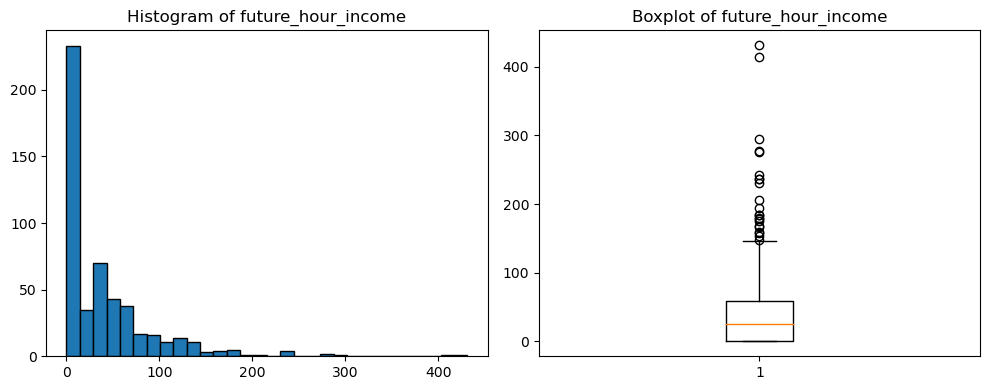

Number of missing values: 0


In [16]:
check_target_variable(df=data, target_col='future_hour_income')

In [17]:
# check_target_variable(df=data, target_col='incomeGroupUp')

In [18]:

data[data.incomeGroupUp==0].head(100)

,id,matzavbriut,k_safaikarit,labour_force_participation,MeanIncomeGroup,hashavani,teudagvoha,k_sug_mosad,m_eretz,mazav,mamadavoda,mekabelsachar,min,semelmishlach,safanosefetanglit,k_semelmiktzlim,incomeGroupUp,future_hour_income,new_mean_k_gova,new_mean_k_mishkal,new_mean_gilGroup,new_mean_k_shnlimklali
0,5990004,VeryGood,Hebrew,0,7777,Never,Post_secondaryschooldiploma_non_academictrack_,other,Israel,Nevermarried,other,other,Male,other,yes,other,0,0.000000,177.0,72.0,23.5,14.0
1,2930001,Good,Hebrew,0,7,YesUsually,Nodiplomaordegree,other,Asia,Widowed,other,other,Male,other,no,other,0,0.000000,167.0,72.0,78.0,NaN
2,10930001,VeryGood,Hebrew,1,7,Rarely,Firstacademicdegree_BAorsimilardegree_,other,Israel,Married,SelfEmployed,other,Male,Managers,yes,business,0,0.000000,190.0,87.0,43.0,16.0
3,42280001,NotsoGood,Russian,1,5640,Never,Primaryschoolorintermediateschooldiploma,other,Euorope_America,Divorced,Employed,FromWorkingPlace,Male,Managers,yes,other,0,33.125000,NaN,107.0,53.0,14.0
5,49270002,VeryGood,Hebrew,0,7,YesUsually,Post_secondaryschooldiploma_non_academictrack_,other,Israel,Married,other,other,Female,other,yes,other,0,0.000000,162.0,57.0,33.0,16.0
7,44400002,VeryGood,Hebrew,1,25628,Never,Secondacademicdegree_MAorsimilardegree_incl_me...,AcademidColleges,Euorope_America,Nevermarried,Employed,FromWorkingPlace,Female,AcademicPreffesionals,yes,business,0,98.795455,157.0,57.0,33.0,16.0
8,830001,VeryGood,Hebrew,0,7,Never,Secondacademicdegree_MAorsimilardegree_incl_me...,Univercities,Israel,Widowed,SelfEmployed,other,Female,AcademicPreffesionals,yes,Teachertrainingandeducationscience,0,0.000000,167.0,62.0,63.0,16.0
10,44770001,Good,Hebrew,0,7,Never,Nodiplomaordegree,other,Africa,Widowed,other,other,Female,other,no,other,0,0.000000,162.0,72.0,73.0,9.5
11,34230005,NotsoGood,Russian,0,7,Never,Primaryschoolorintermediateschooldiploma,other,Euorope_America,Widowed,other,other,Female,other,no,other,0,0.000000,157.0,NaN,63.0,11.5
12,14010002,VeryGood,Hebrew,1,11576,Rarely,Primaryschoolorintermediateschooldiploma,other,Israel,Married,SelfEmployed,other,Male,Building_metals_electricity_printingandsuchpro...,no,other,0,0.000000,172.0,92.0,43.0,16.0


# 3. להציג בצורה ויזואלית  מתאם בין שלשה משתנים כלשהם (אחד רציף ושניים קטגוריאלים ) לבין משתנה ה  incomeGroupUp  (יש לצרף סקריפט, פלטים  של הגרפים והסבר מילולי על הקשרים)


# We will perform several tests,
# We will use graphs like boxplots to look at all the variables together,
# We will do Perform one-way ANOVA test to see the relation of the target and continuous variable, 
# and Cramer's V for the categorical variables with the target

In [19]:
# print(data.info())

# Perform one-way ANOVA

In [29]:
from scipy.stats import shapiro, levene
import pandas as pd

def check_anova_conditions(df, dep_var, ind_var):
    """
    Checks if the conditions for conducting an ANOVA test are met.
    
    Parameters:
    df (DataFrame): The pandas DataFrame containing the data.
    dep_var (str): The name of the column in df representing the dependent variable.
    ind_var (str): The name of the column in df representing the independent variable.
    
    Returns:
    str: Message indicating if conditions for ANOVA are met or not.
    """
    # Checking if dependent variable is numeric
    if df[dep_var].dtype not in [float, int]:
        print("Dependent variable is not numeric.")
        return False
    else:
        print("Condition met: Dependent variable is numeric.")
    
    # Checking if independent variable is categorical and has three or more levels
    if df[ind_var].dtype not in [object, pd.Categorical]:
        print("Independent variable is not categorical.")
        return False
    elif df[ind_var].nunique() < 3:
        print("Independent variable does not have at least three levels.")
        return False
    else:
        print("Condition met: Independent variable is categorical and has at least three levels.")
    
    # Checking normality of dependent variable (using Shapiro-Wilk test)
    # Null hypothesis: data is drawn from normal distribution
    stat, p = shapiro(df[dep_var])
    if p < 0.05:
        print("Dependent variable does not follow normal distribution.")
        return False
    else:
        print("Condition met: Dependent variable follows normal distribution.")
    
    # Checking homogeneity of variances (using Levene's test)
    # Null hypothesis: all input samples are from populations with equal variances
    groups = [group[1][dep_var].values for group in df.groupby(ind_var)]
    stat, p = levene(*groups)
    if p < 0.05:
        print("Variances are not equal across groups.")
        return False
    else:
        print("Condition met: Variances are equal across groups.")

    print("All conditions for ANOVA test are met.")
    return True


print(check_anova_conditions(df = data,dep_var = "new_mean_gilGroup", ind_var="k_semelmiktzlim"))

Condition met: Dependent variable is numeric.
Condition met: Independent variable is categorical and has at least three levels.
Condition met: Dependent variable follows normal distribution.
Condition met: Variances are equal across groups.
All conditions for ANOVA test are met.
True


In [31]:
from scipy.stats import shapiro, levene, f_oneway
import pandas as pd

def anova_test(df, dep_var, ind_var):
    """
    Conducts an ANOVA test after checking for the necessary conditions.
    
    Parameters:
    df (DataFrame): The pandas DataFrame containing the data.
    dep_var (str): The name of the column in df representing the dependent variable.
    ind_var (str): The name of the column in df representing the independent variable.
    
    Returns:
    F-statistic and p-value of the ANOVA test if conditions are met, or an appropriate message.
    """
    
    # Check ANOVA conditions
    conditions_met = check_anova_conditions(df, dep_var, ind_var)
    if not conditions_met:
        return "Conditions for ANOVA test are not met."
    
    # If conditions are met, perform ANOVA
    groups = [group[1][dep_var].values for group in df.dropna().groupby(ind_var)]
    f_statistic, p_value = f_oneway(*groups)

    # Interpret results
    print(f"\nANOVA results for {dep_var} based on {ind_var}:\n")
    print(f"F-statistic: {f_statistic}\n")
    print(f"p-value: {p_value}\n")

    if p_value < 0.05:
        print(f"The differences between the means of {ind_var} categories are statistically significant for {dep_var}.\n")
    else:
        print(f"The differences between the means of {ind_var} categories are not statistically significant for {dep_var}.\n")

    return f_statistic, p_value

anova_test(df=data,dep_var = "new_mean_gilGroup", ind_var="k_semelmiktzlim")

Condition met: Dependent variable is numeric.
Condition met: Independent variable is categorical and has at least three levels.
Condition met: Dependent variable follows normal distribution.
Condition met: Variances are equal across groups.
All conditions for ANOVA test are met.

ANOVA results for new_mean_gilGroup based on k_semelmiktzlim:

F-statistic: 1.8186853619750827

p-value: 0.05717565135660786

The differences between the means of k_semelmiktzlim categories are not statistically significant for new_mean_gilGroup.



(1.8186853619750827, 0.05717565135660786)

In [186]:

data_g = data.dropna(subset=['new_mean_gilGroup', 'incomeGroupUp'])
# Splitting the 'new_mean_gilGroup' data based on 'incomeGroupUp' categories
grouped_data = [data_g['new_mean_gilGroup'][data_g['incomeGroupUp'] == group] for group in data_g['incomeGroupUp'].unique()]

# Perform one-way ANOVA
f_val, p_val = stats.f_oneway(*grouped_data)

print(f"F-value: {f_val}")
print(f"P-value: {p_val}")
print('the p-value is small (below 0.05), we can reject the null hypothesis that the means of "new_mean_gilGroup" are the same across all income groups')
print('In this case, we can say that the difference in means is statistically significant.')

F-value: 57.01256575064807
P-value: 2.0412008386916183e-13
the p-value is small (below 0.05), we can reject the null hypothesis that the means of "new_mean_gilGroup" are the same across all income groups
In this case, we can say that the difference in means is statistically significant.


# we can use also a boxplot to see the distribution

<Figure size 2000x1000 with 0 Axes>

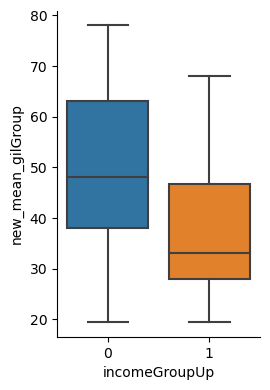

In [187]:
plt.figure(figsize=(20, 10))
sns.catplot(data=data, x="incomeGroupUp", y="new_mean_gilGroup",
             kind="box", height=4, aspect=.7);
plt.show()


# Cramer's V incomeGroupUp and matzavbriut

In [188]:

# Cramér's V measures the strength of the association between variables

contingency_table = pd.crosstab(data['incomeGroupUp'], data['matzavbriut'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1

# Cramer's V
V = np.sqrt((chi2/n) / min_dim)

print(f"Cramer's V: {V}")
print("Cramér's V of 0.2 suggests a weak association between the two categorical variables. This indicates that there is some relationship between the two variables, but it is not very strong.")

Cramer's V: 0.2147683733778698
Cramér's V of 0.2 suggests a weak association between the two categorical variables. This indicates that there is some relationship between the two variables, but it is not very strong.


# Cramer's V incomeGroupUp and k_safaikarit


In [189]:
# Cramér's V measures the strength of the association between variables
contingency_table = pd.crosstab(data['incomeGroupUp'], data['k_safaikarit'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1

# Cramer's V
V = np.sqrt((chi2/n) / min_dim)

print(f"Cramer's V: {V}")
print("Cramér's V of 0.0877 suggests a very weak association between the two categorical variables. This indicates that there is some relationship between the two variables, but it is not very strong.")

Cramer's V: 0.08775017218403525
Cramér's V of 0.0877 suggests a very weak association between the two categorical variables. This indicates that there is some relationship between the two variables, but it is not very strong.


# use graphs like boxplots to look at all the variables together

## People from class 1 (MeanIncomeGroup=1) - on average earn less, it is possible that the upgrade is mainly in the group in the lower socioeconomic clusters

<Figure size 3000x1000 with 0 Axes>

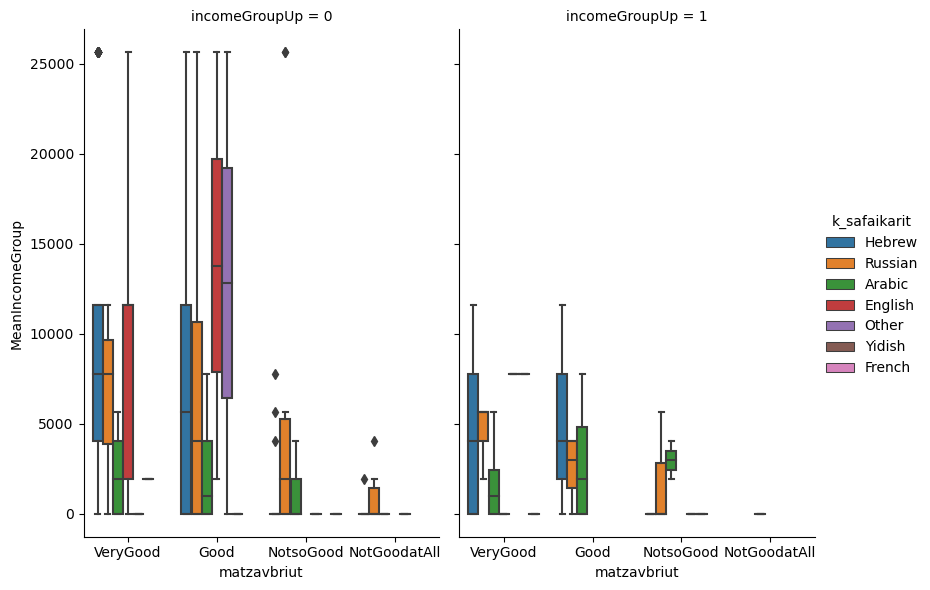

In [190]:


plt.figure(figsize=(30, 10))
sns.catplot(data=data, x="matzavbriut", y="MeanIncomeGroup", hue="k_safaikarit", 
            col="incomeGroupUp", kind="box", height=6, aspect=.7);
plt.show()


# Among group 1 (MeanIncomeGroup=1) - the average age was younger for all groups of language speakers

<Figure size 3000x1000 with 0 Axes>

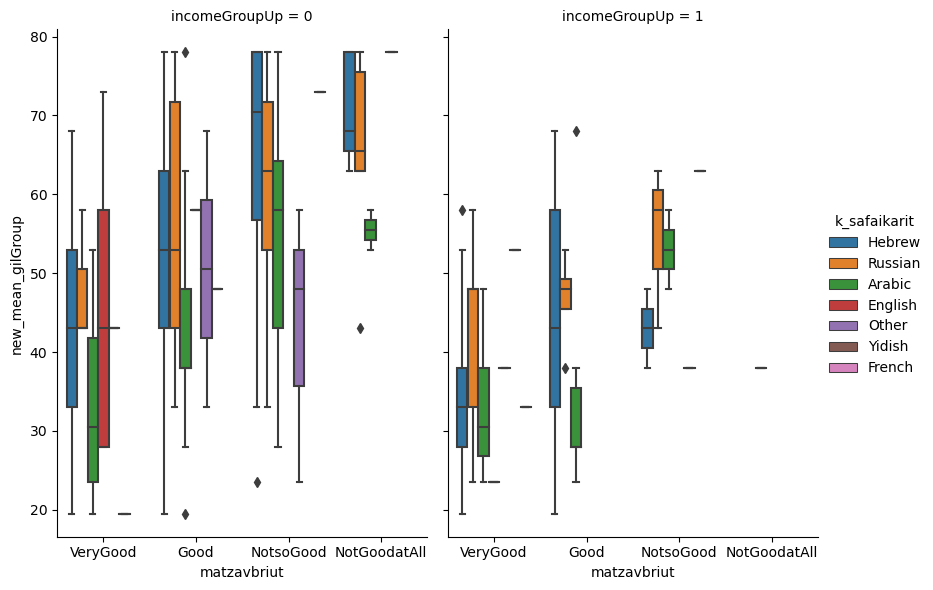

In [191]:
plt.figure(figsize=(30, 10))
sns.catplot(data=data, x="matzavbriut", y="new_mean_gilGroup", hue="k_safaikarit", 
            col="incomeGroupUp", kind="box", height=6, aspect=.7);
plt.show()


# plot all the data with respect to the target variable

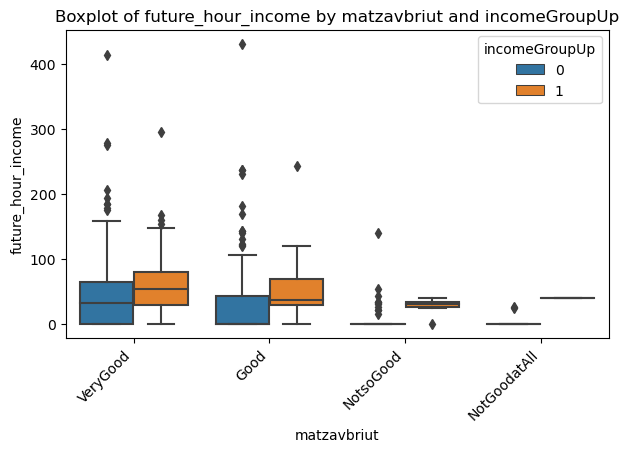

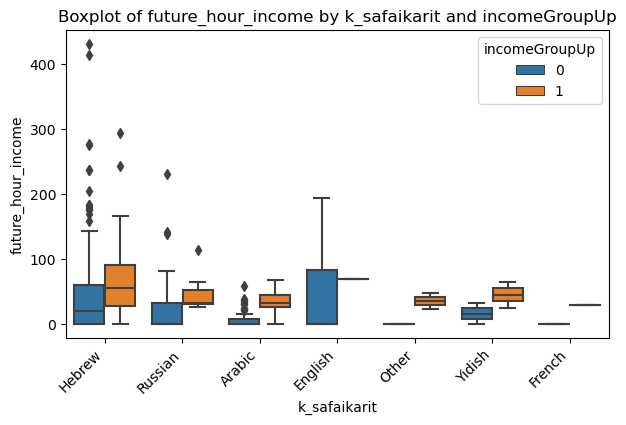

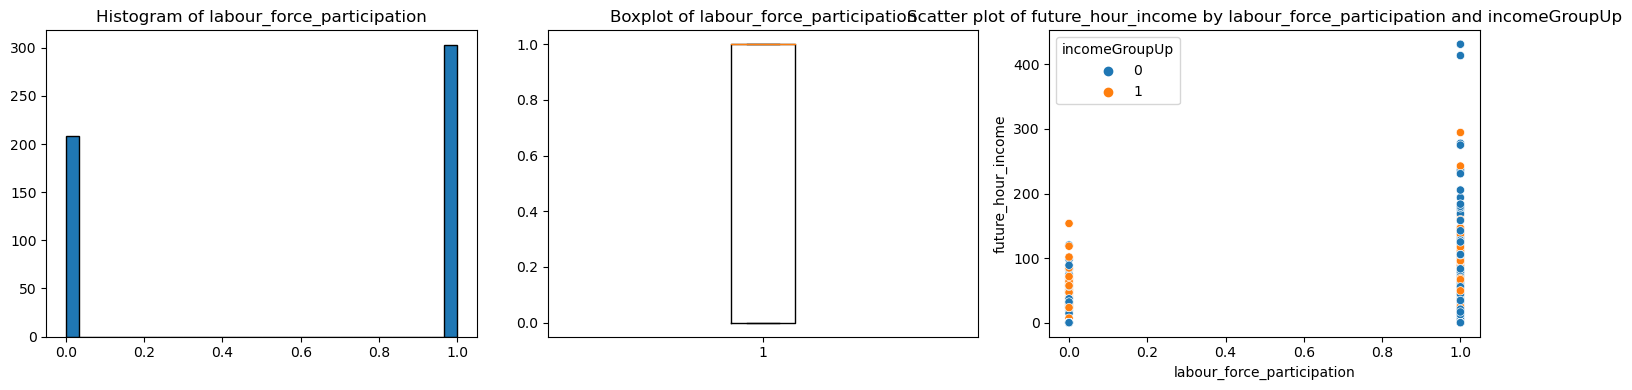

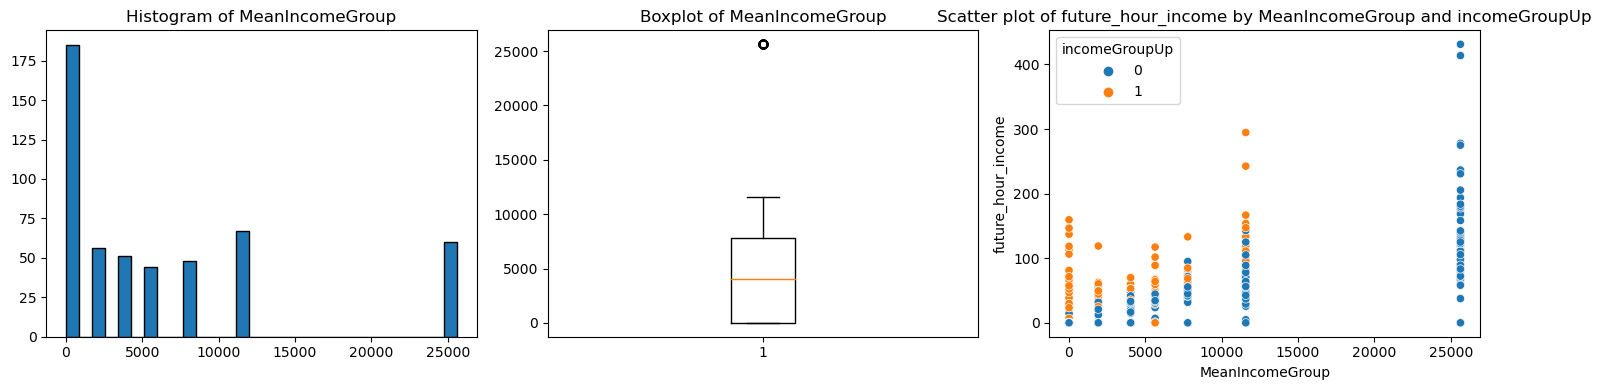

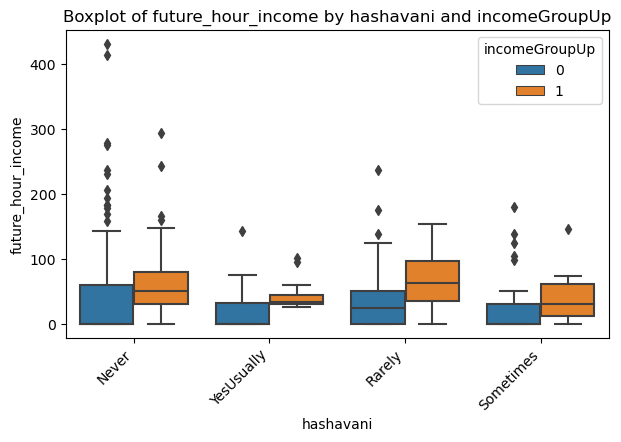

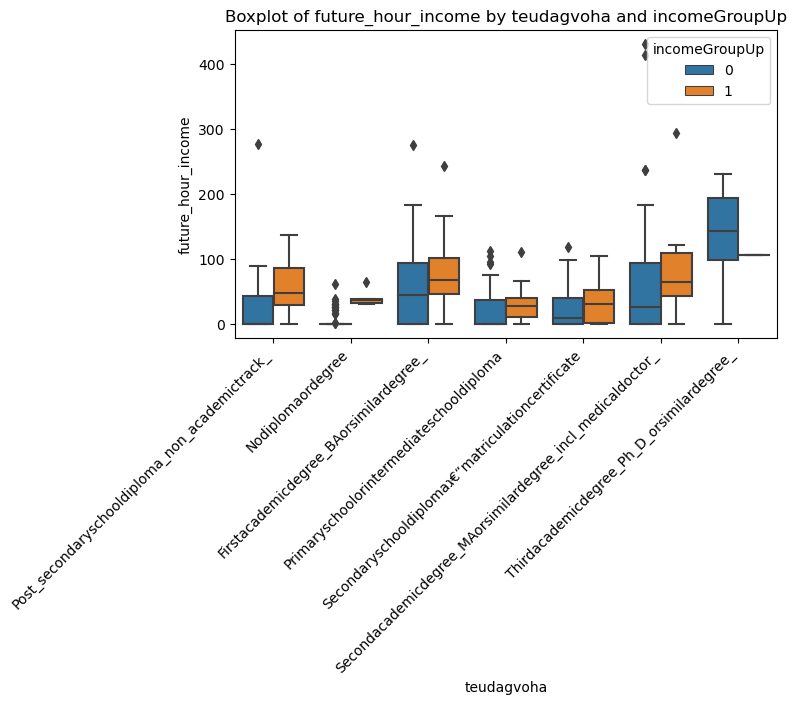

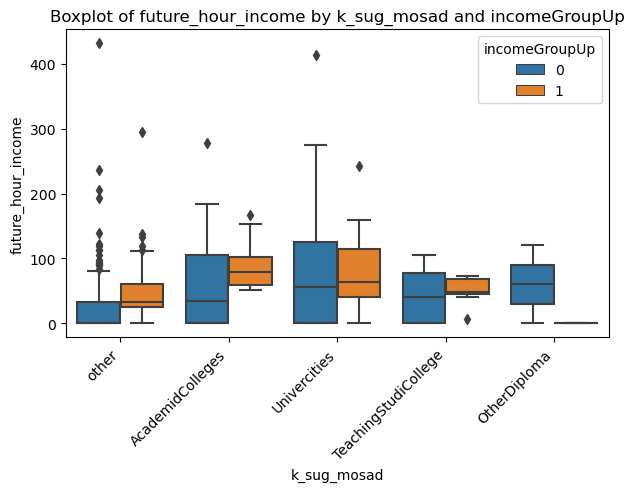

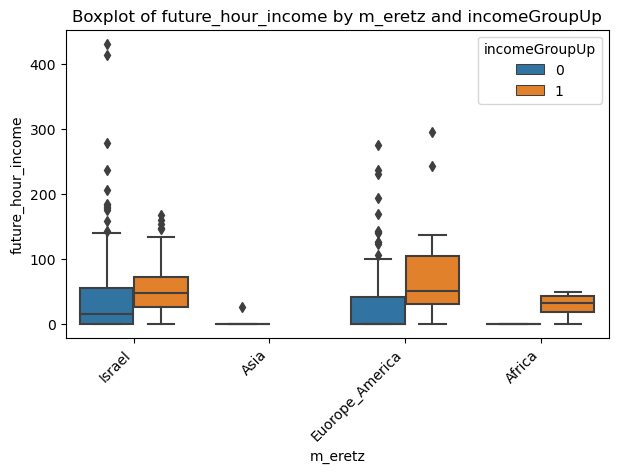

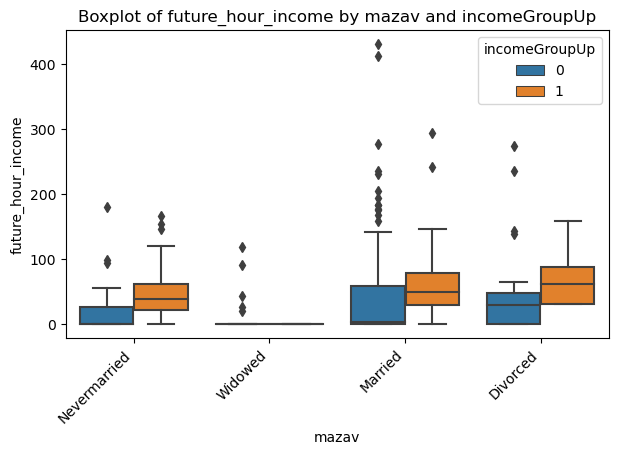

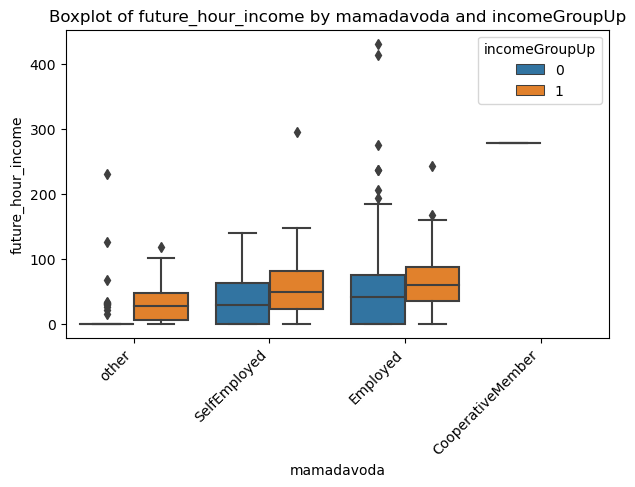

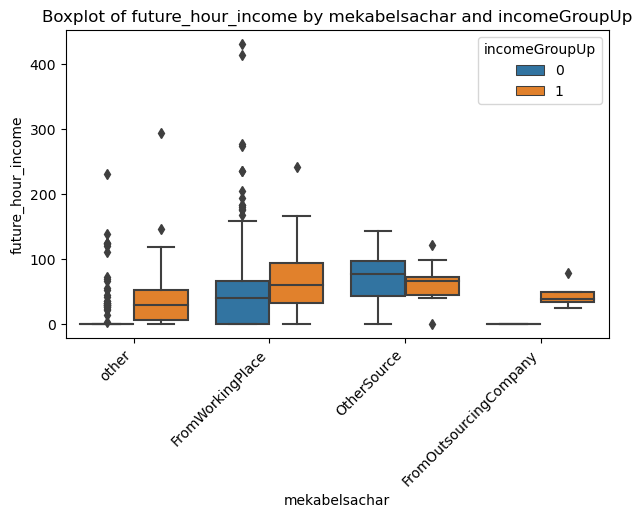

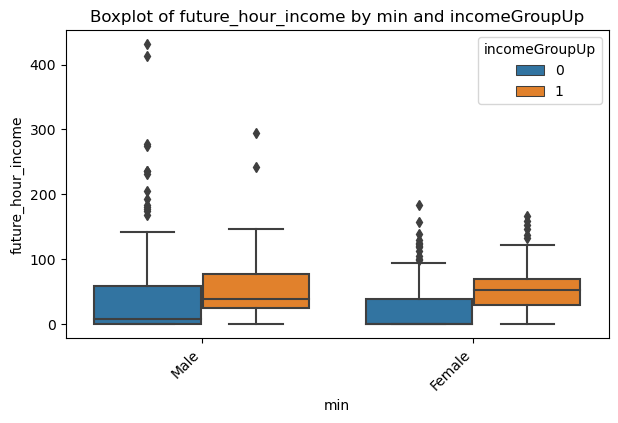

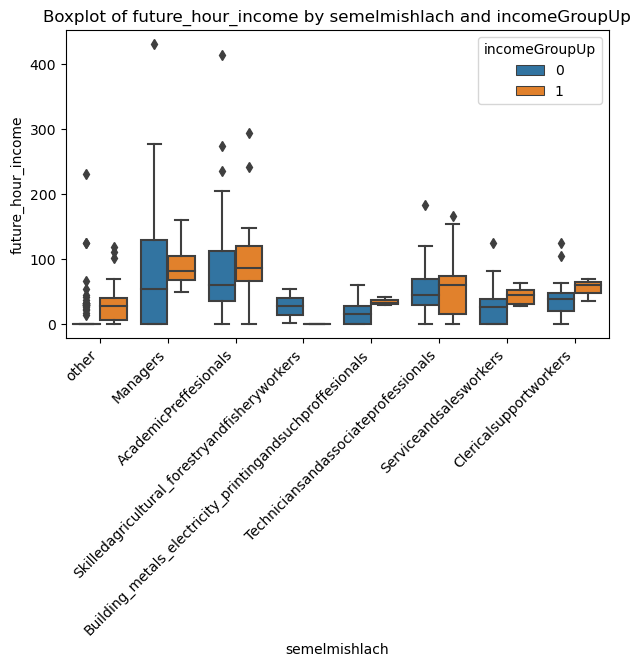

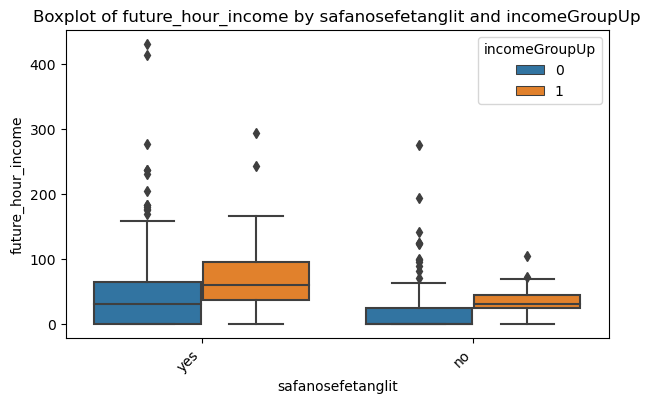

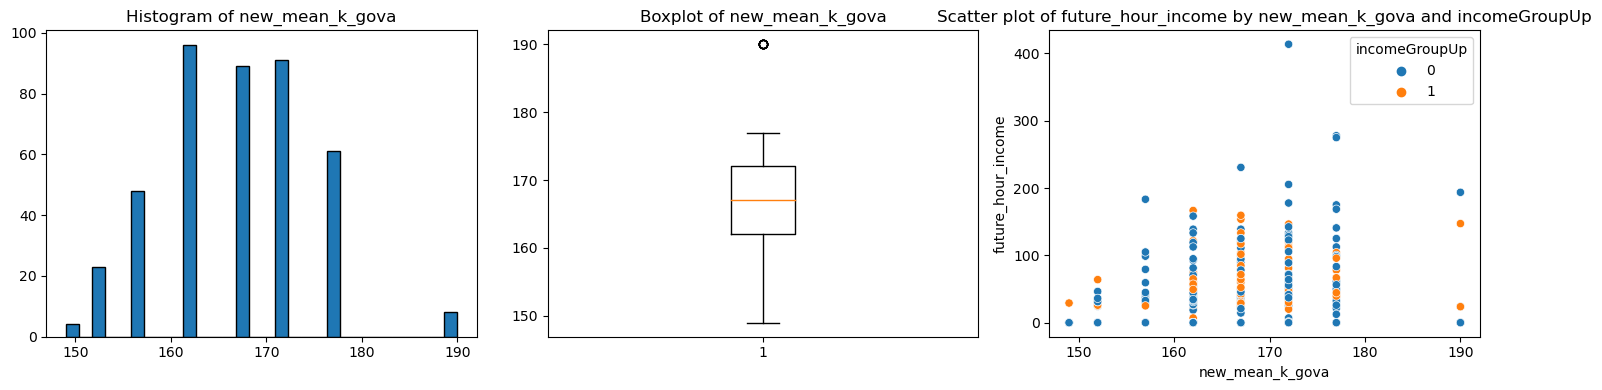

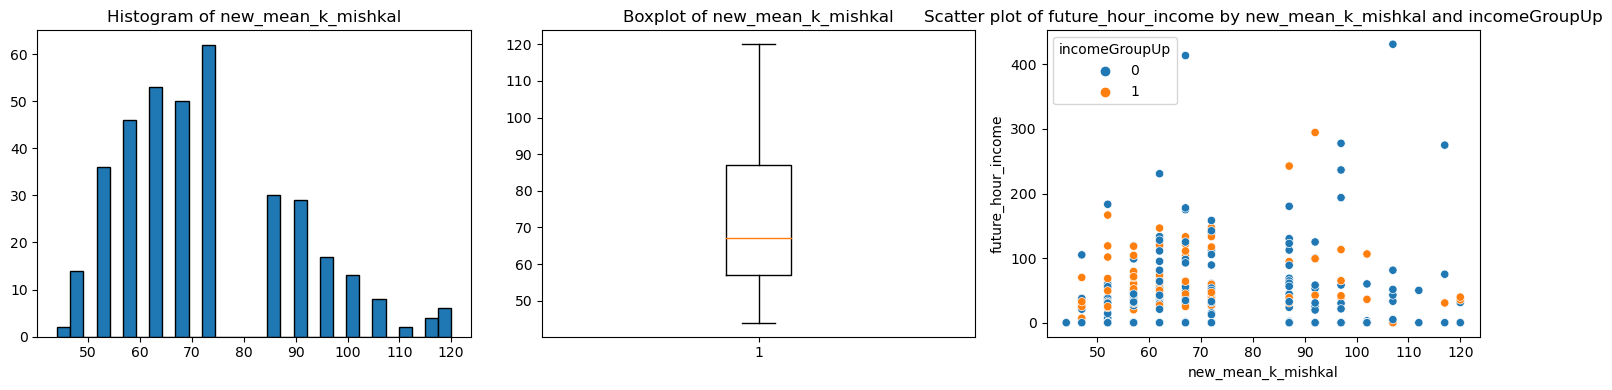

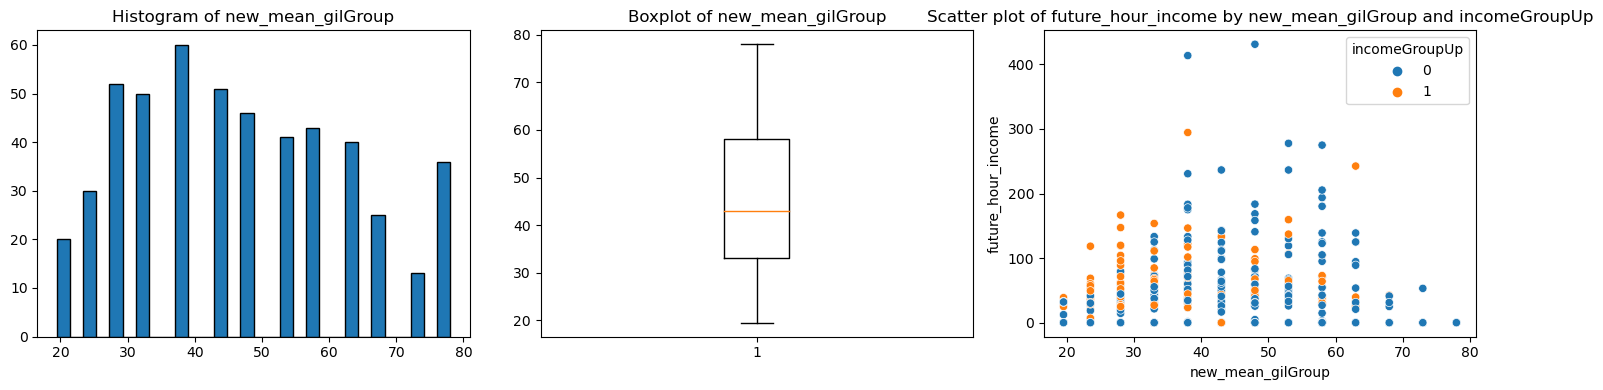

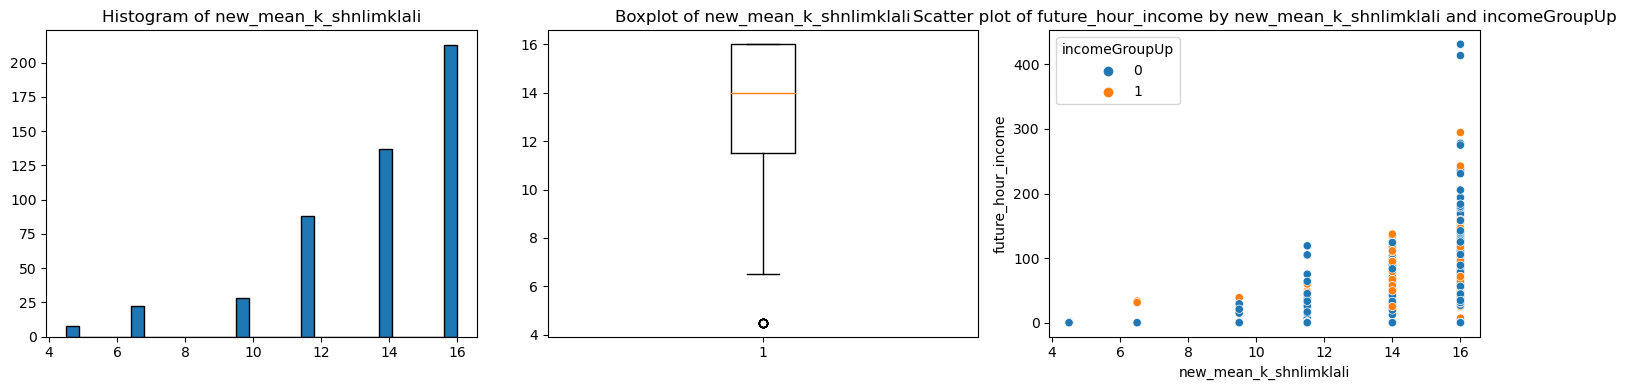

high cardinality column: []


In [214]:
plot_data(df=data, 
          max_categories=10, continuous_col='future_hour_income', hue_col='incomeGroupUp')

# במידה והיית בונה מודלים  לחיזוי ערכי  ה  incomeGroupUp  ,   Future_hour_income  על סמך שאר השדות, איזה מודל נתונים יכול להתאים? 
#      כתוב את סדר הפעולות ל - 2 מודלים אפשריים : אימון + חיזוי . שלב שורות קוד מתאימות בהסבר



# for the prediction of incomeGroupUp we will build a classification  model
# for the prediction of Future_hour_income we will build a regression model
# each model will have its own evaluation method 
# because of time, i will show only the classification part

# below are all the steps

# feature engineering


# step 1 -  split the data 

In [193]:
# high cardinality for now we drop it
irrelevante_columns = ['k_semelmiktzlim','id']
data = data.drop(columns = irrelevante_columns)
X = data.drop(['incomeGroupUp','future_hour_income'], axis=1)  # Replace 'target_column' with the actual target column name
y2 = data['future_hour_income']
y1 = data['incomeGroupUp']
# Split the data into train and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=42)

# Print the shapes of the train and test sets
print("Train1 set shape:", X_train1.shape, y_train1.shape)
print("Test1 set shape:", X_test1.shape, y_test1.shape)

print("Train2 set shape:", X_train2.shape, y_train2.shape)
print("Test2 set shape:", X_test2.shape, y_test2.shape)

Train1 set shape: (408, 18) (408,)
Test1 set shape: (103, 18) (103,)
Train2 set shape: (408, 18) (408,)
Test2 set shape: (103, 18) (103,)


# step 2 - Fill missing values

In [194]:
# The choice of method depends on the nature of the data and the specific problem we are working on. 
# Here are some commonly used methods:

# the basic approach
# Mean/Median/Mode Imputation: suitable for numeric (continuous) or categorical variables. 
# The mean is commonly used for numeric variables, the mode is used for categorical variables.

# Forward Fill (or Backward Fill): Propagate the last observed value forward or the next observed value backward to fill missing values. 
# suitable time series data

# Interpolation: Estimate missing values based on the values of neighboring data points. 

# Hot-Deck Imputation: Fill missing values by randomly selecting values from similar observations or from the same dataset. 
# This method is useful when missing values are related to specific groups or clusters in the data.

# Model-based Imputation: Build a predictive model using the other variables in the dataset and use it to predict missing values. 

# Domain-specific Imputation: Use domain knowledge or expert input to fill missing values. 
# This method can be valuable when there are specific rules or known relationships in the data that can guide the imputation process.

In [247]:
# # the basic approach
# # Fill missing values and get the dictionary of fill values
# # we create the dictoinary in the training stage and use it in the production stage 
# fill_values = fill_missing_values(df=X_train1)

# # Display the fill values
# for column, value in fill_values.items():
#     print(f"Column: {column} - Fill Value: {value}")

# # fill the missing values using the dictionary
# X_train1 = X_train1.fillna(fill_values)
# X_test1 = X_test1.fillna(fill_values)

# the basic approach
# Fill missing values and get the dictionary of fill values
# we create the dictoinary in the training stage and use it in the production stage 
fill_values = fill_missing_values(df=X_train2)

# Display the fill values
for column, value in fill_values.items():
    print(f"Column: {column} - Fill Value: {value}")

# fill the missing values using the dictionary
X_train2 = X_train2.fillna(fill_values)
X_test2 = X_test2.fillna(fill_values)

Column: labour_force_participation - Fill Value: 1.0
Column: MeanIncomeGroup - Fill Value: 4039.0
Column: new_mean_k_gova - Fill Value: 167.0
Column: new_mean_k_mishkal - Fill Value: 67.0
Column: new_mean_gilGroup - Fill Value: 43.0
Column: new_mean_k_shnlimklali - Fill Value: 14.0
Column: matzavbriut - Fill Value: VeryGood
Column: k_safaikarit - Fill Value: Hebrew
Column: hashavani - Fill Value: Never
Column: teudagvoha - Fill Value: Firstacademicdegree_BAorsimilardegree_
Column: k_sug_mosad - Fill Value: other
Column: m_eretz - Fill Value: Israel
Column: mazav - Fill Value: Married
Column: mamadavoda - Fill Value: Employed
Column: mekabelsachar - Fill Value: FromWorkingPlace
Column: min - Fill Value: Female
Column: semelmishlach - Fill Value: other
Column: safanosefetanglit - Fill Value: yes


In [196]:
X_train1.head()

,matzavbriut,k_safaikarit,labour_force_participation,MeanIncomeGroup,hashavani,teudagvoha,k_sug_mosad,m_eretz,mazav,mamadavoda,mekabelsachar,min,semelmishlach,safanosefetanglit,new_mean_k_gova,new_mean_k_mishkal,new_mean_gilGroup,new_mean_k_shnlimklali
208,VeryGood,Hebrew,1,7777,Never,Post_secondaryschooldiploma_non_academictrack_,other,Israel,Divorced,SelfEmployed,other,Male,AcademicPreffesionals,no,167.0,67.0,58.0,16.0
204,Good,Hebrew,0,7,Sometimes,Nodiplomaordegree,other,Euorope_America,Married,other,other,Male,other,no,172.0,62.0,78.0,6.5
301,Good,Hebrew,1,25628,Never,Firstacademicdegree_BAorsimilardegree_,Univercities,Israel,Married,Employed,OtherSource,Female,AcademicPreffesionals,yes,162.0,47.0,33.0,16.0
390,VeryGood,Hebrew,1,11576,Never,Secondacademicdegree_MAorsimilardegree_incl_me...,Univercities,Israel,Married,Employed,FromWorkingPlace,Female,Techniciansandassociateprofessionals,yes,162.0,62.0,38.0,16.0
416,VeryGood,Hebrew,0,7,Never,Secondaryschooldiplomaג€“matriculationcertificate,TeachingStudiCollege,Israel,Married,other,other,Female,other,no,162.0,47.0,23.5,16.0


# encoding high cardinality columns


In [197]:
# encoding high cardinality columns
# high_car_columns = []
# freq_dict, X_train = frequency_encoding(data=X_train, column='', mode='train', freq_dict=None)
# X_test = frequency_encoding(data=X_test, column='', mode='production', freq_dict=freq_dict)

        
# # print(freq_dict)
# print(X_train.shape)
# print(X_test.shape)
# X_train.head()

In [198]:
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 408 entries, 208 to 102
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   matzavbriut                 408 non-null    object 
 1   k_safaikarit                408 non-null    object 
 2   labour_force_participation  408 non-null    int32  
 3   MeanIncomeGroup             408 non-null    int64  
 4   hashavani                   408 non-null    object 
 5   teudagvoha                  408 non-null    object 
 6   k_sug_mosad                 408 non-null    object 
 7   m_eretz                     408 non-null    object 
 8   mazav                       408 non-null    object 
 9   mamadavoda                  408 non-null    object 
 10  mekabelsachar               408 non-null    object 
 11  min                         408 non-null    object 
 12  semelmishlach               408 non-null    object 
 13  safanosefetanglit           408 non-nu

# step 3 - One Hot Encoding

In [248]:
# final_categorical_cols = X_train1.select_dtypes(include='object').columns.tolist()
# final_numeric_cols = X_train1.select_dtypes(exclude='object').columns.tolist()
# encoder, X_train1 = one_hot_encode(data=X_train1, 
#                                   categorical_columns=final_categorical_cols, 
#                                   mode='train', encoder=None)
# X_test1 = one_hot_encode(data=X_test1,
#                          categorical_columns=final_categorical_cols, 
#                          mode='production', encoder=encoder)


final_categorical_cols = X_train2.select_dtypes(include='object').columns.tolist()
final_numeric_cols = X_train2.select_dtypes(exclude='object').columns.tolist()
encoder, X_train2 = one_hot_encode(data=X_train2, 
                                  categorical_columns=final_categorical_cols, 
                                  mode='train', encoder=None)
X_test2 = one_hot_encode(data=X_test2,
                         categorical_columns=final_categorical_cols, 
                         mode='production', encoder=encoder)

train (408, 54) (408, 6)
production (103, 54) (103, 6)


In [200]:
X_train1.head()

,matzavbriut_Good,matzavbriut_NotGoodatAll,matzavbriut_NotsoGood,matzavbriut_VeryGood,k_safaikarit_Arabic,k_safaikarit_English,k_safaikarit_Hebrew,k_safaikarit_Other,k_safaikarit_Russian,k_safaikarit_Yidish,...,semelmishlach_Techniciansandassociateprofessionals,semelmishlach_other,safanosefetanglit_no,safanosefetanglit_yes,labour_force_participation,MeanIncomeGroup,new_mean_k_gova,new_mean_k_mishkal,new_mean_gilGroup,new_mean_k_shnlimklali
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1,7777,167.0,67.0,58.0,16.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0,7,172.0,62.0,78.0,6.5
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1,25628,162.0,47.0,33.0,16.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1,11576,162.0,62.0,38.0,16.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0,7,162.0,47.0,23.5,16.0


# step 4 -  scale the data

In [250]:
# X_train_scaled1, scaler = scale_data(df=X_train1, scaler=StandardScaler(), mode='train', cols_to_scale=final_numeric_cols)
# X_test_scaled1, scaler = scale_data(df=X_test1, scaler=scaler, mode='production', cols_to_scale=final_numeric_cols)
# print(f'shape of X_train_scaled1: {X_train_scaled1.shape}')
# print(f'shape of X_test_scaled1: {X_test_scaled1.shape}')

X_train_scaled2, scaler = scale_data(df=X_train2, scaler=StandardScaler(), mode='train', cols_to_scale=final_numeric_cols)
X_test_scaled2, scaler = scale_data(df=X_test2, scaler=scaler, mode='production', cols_to_scale=final_numeric_cols)
print(f'shape of X_train_scaled2: {X_train_scaled2.shape}')
print(f'shape of X_test_scaled2: {X_test_scaled2.shape}')

shape of X_train_scaled2: (408, 60)
shape of X_test_scaled2: (103, 60)


# A side check to get information on the immediate effect of each parameter

# influence of each parameter on the target variable

# feature importance using a tree-based model and plot the results 

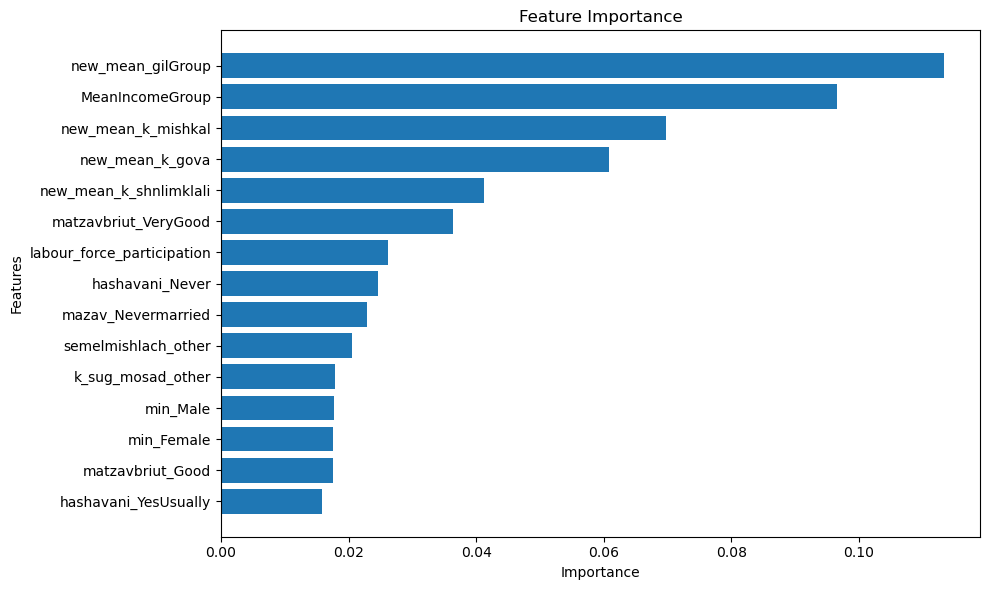

In [208]:


# Feature Importance from Tree-based Models: Tree-based models, such as Random Forest or Gradient Boosting, 
# provide feature importance scores that reflect the contribution of each feature in the decision-making process. 
# This can be used to assess the influence of variables across different data types.


# Create a Random Forest classifier
model = RandomForestClassifier()

# Fit the model to the data
model.fit(X_train_scaled1, y_train1)

# Get feature importances
importances = model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
# Specify the number of top features you want to plot
k = 15 

# Get the names of the features
feature_names = [f"{X_train_scaled1.columns[i]}" for i in sorted_indices[:k]]

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1][:k]
sorted_importances = importances[sorted_indices]


# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(k), sorted_importances, tick_label=feature_names)
plt.gca().invert_yaxis()  # invert the y-axis to have the feature with the highest importance at the top
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# more relevant for the regression part - correlation, only for the numeric columns
# we can see that from all numeric features - MeanIncomeGroup have the most effect on the target. and after new_mean_gilGroup

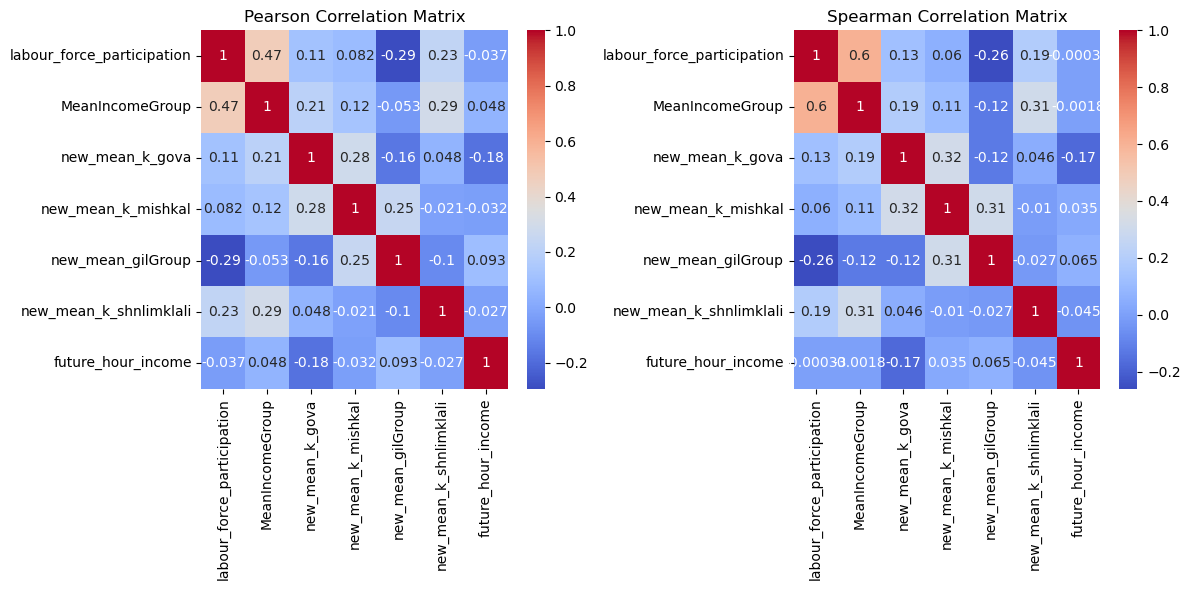

In [251]:

# assuming you have a pandas DataFrame df
corr_df = pd.concat([X_train_scaled2[final_numeric_cols],y_train2],axis=1)

# Pearson correlation matrix
pearson_corr_matrix = corr_df.corr(method='pearson')

# Spearman correlation matrix
spearman_corr_matrix = corr_df.corr(method='spearman')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm')
plt.title("Pearson Correlation Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm')
plt.title("Spearman Correlation Matrix")

plt.tight_layout()
plt.show()


# 5. כיצד היית מתקף את תוצאות המודל - כתוב את סדר הפעולות . שלב שורות קוד.


# step 6 - evaluate model performance using cross validation

In [ ]:
# in order to evaluate each model's performance we use cross-validation technique
# we set the class_weight='balanced' parameter to address the imbalanced  data problem
# also, we use the following matrices - precision, recall and F1-score
# we use StratifiedKFold to get same distribution of the target in each train step
# a standard method is to choose the model with the best f1-score

In [220]:

# Define the models
models = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(class_weight='balanced')),
    ('SVM', SVC(class_weight='balanced'))
]

metrics = {
    'Precision': make_scorer(precision_score, pos_label=1),
    'Recall': make_scorer(recall_score, pos_label=1),
    'F1-Score': make_scorer(f1_score, pos_label=1)
}

# Perform cross-validation for each model
for model_name, model in models:
    print(f"Model: {model_name}")
    for metric_name, metric_func in metrics.items():
        # we use StratifiedKFold to get same distribution of the target in each train step
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X_train_scaled1, y_train1, cv=cv, scoring=metric_func)
        print(f"{metric_name}: {np.mean(scores):.4f} (std: {np.std(scores):.4f})")
    print()


Model: Logistic Regression
Precision: 0.5109 (std: 0.0906)
Recall: 0.7048 (std: 0.0819)
F1-Score: 0.5860 (std: 0.0639)

Model: Random Forest
Precision: 0.6008 (std: 0.2095)
Recall: 0.1714 (std: 0.0381)
F1-Score: 0.2619 (std: 0.0619)

Model: SVM
Precision: 0.4721 (std: 0.0456)
Recall: 0.7714 (std: 0.0356)
F1-Score: 0.5844 (std: 0.0389)



# There are several methods commonly used to address the imbalanced data problem in machine learning:

In [ ]:
# Resampling Techniques:
# Oversampling: Increase the number of instances in the minority class by randomly replicating existing instances or generating synthetic samples 
# (e.g., using SMOTE - Synthetic Minority Over-sampling Technique).
# Undersampling: Reduce the number of instances in the majority class by randomly removing instances or selecting a subset of instances.
# Combination of Oversampling and Undersampling: Combine both oversampling and undersampling techniques to achieve a balanced dataset.

# Class Weighting:
# Assign different weights to different classes during model training to give more importance to the minority class. This can be done by adjusting the class_weight parameter in various algorithms.

# Ensemble Methods:
# Utilize ensemble methods, such as Bagging or Boosting algorithms, to create multiple models and combine their predictions. These methods can help capture the patterns of both the majority and minority classes.
# Threshold Adjustment:

# Adjust the classification threshold to favor the minority class. This can be useful when the cost of misclassifying the minority class is higher than the majority class.

# the last step is to choose the best model for production 

In [234]:
# Fit the model to the data
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_scaled1, y_train1)

# Make predictions on the test set
y_pred1 = model.predict(X_test_scaled1)

# Evaluate the model by comparing the predictions to the actual values using f1_score
f1 = f1_score(y_test1, y_pred1)

print(f"The F1 score of the model on the test set is: {f1:.2f}")

The F1 score of the model on the test set is: 0.37


# now for the regression part we use the same steps 1-6


# we saw earlier that the target variable for the regression prediction has a zero-inflated distribution,which is extremely positively skewed

In [ ]:
# Zero-inflated target variables can be a challenge for many traditional statistical and machine learning models. 
# However, there are several strategies to handle such situations:

# Two-Step Models: You could approach this as a two-step process. 
# The first step would involve modeling whether the target is zero or not (binary classification problem) 
# using a classification algorithm. 
# The second step would involve modeling the non-zero targets using a regression model. 
# The combination of the two models should give a good representation of the zero-inflated target variable.

# Zero-Inflated Models: 
# These are statistical models specifically designed to handle zero-inflated data. 
# Zero-inflated Poisson (ZIP) and zero-inflated negative binomial (ZINB) models are two of the most commonly used ones. 
# These models basically combine a model for count data (like Poisson or negative binomial) with a model for generating zeroes. 
# This approach works particularly well when the data is count data with excess zeroes.


# for evaluation let's replace the classifier models with regression models, and update the metrics to ones appropriate for regression.
# also, we use K Fold and not StratifiedKFold because we don't care about the distribution of the target
# The choice between these depends on what you prioritize in your specific problem - whether it is more important to correctly predict zero vs non-zero (classification), or to accurately predict the count when it's non-zero (regression).

In [262]:
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.discrete.count_model import ZeroInflatedPoisson, NegativeBinomialP

# Define the Zero-Inflated models:
models = [
    ('Zero Inflated Poisson', sm.ZeroInflatedPoisson),
    ('Zero Inflated Negative Binomial', sm.ZeroInflatedNegativeBinomialP)
]
X_train_scaled1 = X_train_scaled1.reset_index(drop=True)
y_train2 = y_train2.reset_index(drop=True)
# Perform cross-validation for each model
for model_name, model in models:
    print(f"Model: {model_name}")
    
    # Initialize the cross-validation folds
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    mae_scores = []  # Mean Absolute Error Scores
    acc_scores = []  # Accuracy Scores
    
    for train, test in kfold.split(X_train_scaled2, y_train2):
        # Fit the model
        res = model(endog=y_train2.iloc[train], exog=X_train_scaled2.iloc[train], exog_infl=sm.add_constant(X_train_scaled2.iloc[train])).fit()
        
        # Make predictions
        y_pred = res.predict(X_train_scaled2.iloc[train])
        
        # Compute the Mean Absolute Error and append to the scores list
        mae_scores.append(mean_absolute_error(y_train2.iloc[test], y_pred))
        
        # Compute accuracy of zero prediction
        y_pred_zero = y_pred < 0.5
        y_true_zero = y_train2.iloc[test] == 0
        acc_scores.append(accuracy_score(y_true_zero, y_pred_zero))
    
    # Print the mean and standard deviation of the metrics
    print(f"Mean Absolute Error: {np.mean(mae_scores):.4f} (std: {np.std(mae_scores):.4f})")
    print(f"Zero Prediction Accuracy: {np.mean(acc_scores):.4f} (std: {np.std(acc_scores):.4f})")
    print()



Model: Zero Inflated Poisson
         Current function value: 5.167265
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41


C:\Users\nirro\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\nirro\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nirro\anaconda3\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\nirro\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


NameError: name 'mean_absolute_error' is not defined

In [ ]:
# Fit the model to the data
model = ZeroInflatedPoisson()
model.fit(X_train_scaled2, y_train2)

# Make predictions on the test set
y_pred2 = model.predict(X_test_scaled2)

# Evaluate the model by comparing the predictions to the actual values using f1_score
accuracy_score = accuracy_score(y_test2, y_pred2)

print(f"The F1 score of the model on the test set is: {accuracy_score:.2f}")